In [1]:
import os
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from models.t0 import T0RegressionModel
from datahandles import TabLLMDataObject, FewshotTabLLMDataset, CombinedTabLLMTextDataset
from tabllm.dataset_utils import load_dataset, balance_dataset, load_and_preprocess_dataset
from utils import Config, ConfigObject

os.environ["HF_HOME"] = "/export/pasan/.cache/huggingface"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

/afs/glue.umd.edu/home/glue/p/a/pasand/home/miniconda3/envs/transhyper2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False, cmap='Blues'):
    """
    Displays a confusion matrix.

    Parameters:
    - y_true: list or array of true labels
    - y_pred: list or array of predicted labels
    - class_names: list of class names (optional)
    - normalize: whether to normalize the matrix (default: False)
    - cmap: color map for the heatmap
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()

In [3]:
checkpoint_path = f"save/t0pp-twotrain-bank-income/epoch-6.pth"

checkpoint = torch.load(checkpoint_path, weights_only=False)
cfg = Config(cfg_dict=checkpoint["cfg"])
model = T0RegressionModel(cfg=cfg)
model.load_state_dict(checkpoint['model'])
tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer.model())

Hyponet mlp initialized with parameter shapes {'wb0': (104, 10), 'wb1': (11, 10), 'wb2': (11, 10), 'wb3': (11, 2)}
Initializing hypernet t0, name: t0, model: bigscience/T0pp
t0 hypernet hidden size: 4096
total hyponet params: 1282


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
ds_name = "calhousing"

cfg_dict = checkpoint["cfg"]
cfg_dict["datasets"]["list_combine_test"] = [ds_name]
cfg_dict["datasets"]["balanced"] = {"train": True, "val": False, "test": False}
cfg_dict["datasets"]["tabllm"]["txt_data_path"] = "tabllm/data/datasets_serialized"
cfg_dict["datasets"]["test_ratio"] = 0.8
cfg_dict["datasets"]["validation_ratio"] = 0.1
cfg_dict["debug"] = False
cfg = Config(cfg_dict=cfg_dict)

tabllm_do = TabLLMDataObject(cfg=cfg, set_hyponet_in_dim=False)
test_ds = CombinedTabLLMTextDataset(cfg=cfg, split="test", datapoints=[tabllm_do.split_datapoints[ds_name]], max_n_features=cfg.hyponet.in_dim())

y = np.array([test_ds[i]["y"] for i in range(len(test_ds))])
X = np.array([test_ds[i]["x"] for i in range(len(test_ds))])
print(f"X.shape: {X.shape}, y.shape: {y.shape}")

X.shape: (16513, 103), y.shape: (16513,)


In [5]:
cfg_dict["datasets"]["list_combine_test"] = ['income']
cfg_dict["datasets"]["balanced"] = {"train": True, "val": False, "test": False}
cfg_dict["datasets"]["tabllm"]["txt_data_path"] = "tabllm/data/datasets_serialized"
cfg_dict["datasets"]["test_ratio"] = 0.8
cfg_dict["datasets"]["validation_ratio"] = 0.1
cfg_dict["debug"] = False
cfg = Config(cfg_dict=cfg_dict)

tabllm_do = TabLLMDataObject(cfg=cfg, set_hyponet_in_dim=False)
test_ds = CombinedTabLLMTextDataset(cfg=cfg, split="test", datapoints=[tabllm_do.split_datapoints[ds_name]], max_n_features=cfg.hyponet.in_dim())

In [5]:
W = X

In [6]:
# X = W[:, np.random.randint(low=0, high=np.random.randint(low=0, high=W.shape[1], size=W.shape[1]))]

Dataset: calhousing
Prediction shape: (16513,)
Max const. predictor acc: 50.27
Hyponet balanced acc: 63.60
Hyponet F1 score: 61.64
Hyponet unbalanced acc: 63.57


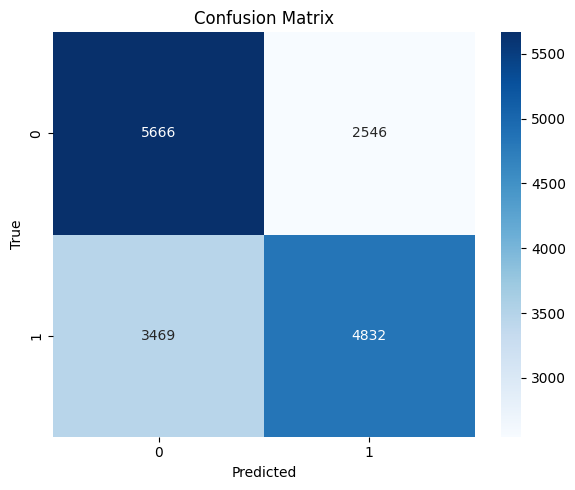

In [14]:
def compute_metrics(n_shots):
    if n_shots > 0:
        prompt = "".join([test_ds[i, True] for i in np.random.randint(low=0, high=len(test_ds), size=n_shots)])
    else:
        prompt = "Quick brown fox jumped over the lazy dog!"
        
    tokens = tokenizer(prompt, 
                    truncation=cfg.tokenizer.truncation(), 
                    padding=cfg.tokenizer.padding(), 
                    max_length=cfg.tokenizer.max_length(), 
                    return_tensors='pt')
    hyponet = model(tokens)
    hyponet.eval()
    preds = hyponet.forward(torch.Tensor(X).unsqueeze(dim=0))
    preds = preds.detach().numpy()
    preds = np.squeeze(preds)
    preds = np.argmax(preds, axis=1)

    val_counts = pd.DataFrame(y).value_counts()
    const_pred_acc = max(val_counts)/sum(val_counts) * 100
    balanced_acc = balanced_accuracy_score(y, preds) * 100
    f1 = f1_score(y, preds) * 100
    unbalanced_acc = accuracy_score(y, preds) * 100

    return {
        "preds": preds,
        "const_predictor_acc": const_pred_acc,
        "balanced_acc": balanced_acc,
        "f1_score": f1,
        "unbalanced_acc": unbalanced_acc
    }


print(f"Dataset: {ds_name}")

metrics = compute_metrics(n_shots=10)
print(f"Prediction shape: {metrics['preds'].shape}")
print(f"Max const. predictor acc: {metrics['const_predictor_acc']:.2f}")
print(f"Hyponet balanced acc: {metrics['balanced_acc']:.2f}")
print(f"Hyponet F1 score: {metrics['f1_score']:.2f}")
print(f"Hyponet unbalanced acc: {metrics['unbalanced_acc']:.2f}")


plot_confusion_matrix(y_true=y, y_pred=metrics["preds"])

In [12]:
balanced_acc = []
unbalanced_acc = []
f1 = []
n_shots_list = [0, 4, 8, 16, 32, 64, 128, 256]
# n_shots_list = [0, 1, 2, 4, 6, 8, 10]

for n_shots in n_shots_list:
    metrics = compute_metrics(n_shots=n_shots)
    balanced_acc.append(metrics['balanced_acc'])
    unbalanced_acc.append(metrics['unbalanced_acc'])
    f1.append(metrics['f1_score'])

Quick brown fox jumped over the lazy dog!
Example: The median income is 3.5772. The median age is 36. The total rooms is 1432. The total bedrooms is 265. The population is 749. The households is 261. The latitude is 33.91. The longitude is -118.12.

Is this house block valuable? Yes or no? Answer:
|||
Yes
Example: The median income is 2.5504. The median age is 26. The total rooms is 3543. The total bedrooms is 1055. The population is 2742. The households is 951. The latitude is 33.96. The longitude is -118.36.

Is this house block valuable? Yes or no? Answer:
|||
No
Example: The median income is 6.0992. The median age is 24. The total rooms is 2001. The total bedrooms is 365. The population is 1170. The households is 330. The latitude is 34.40. The longitude is -119.91.

Is this house block valuable? Yes or no? Answer:
|||
Yes
Example: The median income is 3.2448. The median age is 20. The total rooms is 5756. The total bedrooms is 1477. The population is 4031. The households is 1369. 

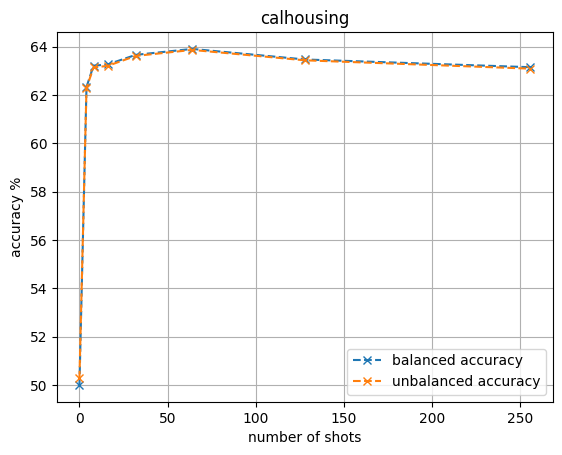

In [13]:
plt.plot(n_shots_list, balanced_acc, 'x--', label="balanced accuracy")
plt.plot(n_shots_list, unbalanced_acc, 'x--', label="unbalanced accuracy")
# plt.plot(n_shots_list, f1, 'x--', label="f1 score")
plt.title(ds_name)
plt.xlabel("number of shots")
plt.ylabel("accuracy %")
plt.grid(True)
plt.legend()
plt.show()